In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize

import nltk
from collections import Counter

# Suppress warnings to keep the output clean
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\aafaq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aafaq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aafaq\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aafaq\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Set pandas display options to show all columns and rows for DataFrames
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)

# Read the CSV file and load it into a DataFrame
df = pd.read_csv('spam.csv', encoding_errors='replace')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
#Data Cleaning
# Drop columns that are not useful for analysis (Unnamed columns)
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)


# Rename the columns for better clarity (Class -> spam/ham, Text -> SMS content)
df.columns = ['Class', 'Text']
df.head()

,Class,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
#Basic Data Exploration
def data_summary(df):
    # Check the shape of the DataFrame (number of rows and columns)
    print("Shape of the DataFrame:", df.shape)
    
    # Display general information about the dataset
    print("\nData Types and Non-Null Counts:")
    print(df.info())
    
    # Check for missing values in each column
    print("\nMissing Values per Column:")
    print(df.isna().sum())
    
    # Check for duplicate rows in the dataset
    print("\nDuplicate Rows Count:", df.duplicated().sum())
    
    # Get a descriptive summary of the object-type columns (Class and Text)
    print("\nDescriptive Statistics for All Columns:")
    print(df.describe())

data_summary(df)

Shape of the DataFrame: (5572, 2)

Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   5572 non-null   object
 1   Text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None

Missing Values per Column:
Class    0
Text     0
dtype: int64

Duplicate Rows Count: 403

Descriptive Statistics for All Columns:
       Class                    Text
count   5572                    5572
unique     2                    5169
top      ham  Sorry, I'll call later
freq    4825                      30


In [5]:
#Handling duplicates
duplicates = df[df.duplicated()]
duplicates.head()

,Class,Text
102,ham,As per your request 'Melle Melle (Oru Minnamin...
153,ham,As per your request 'Melle Melle (Oru Minnamin...
206,ham,"As I entered my cabin my PA said, '' Happy B'd..."
222,ham,"Sorry, I'll call later"
325,ham,No calls..messages..missed calls


In [6]:
# Check the distribution of class (Ham or Spam) among the duplicate rows
print(duplicates['Class'].value_counts())

Class
ham     309
spam     94
Name: count, dtype: int64


In [7]:
# Remove duplicate rows from the DataFrame
df = df.drop_duplicates()

In [8]:
df.shape

(5169, 2)

In [9]:
# Verify that duplicates have been removed and display the updated shapedf.shape
df.duplicated().sum()

0

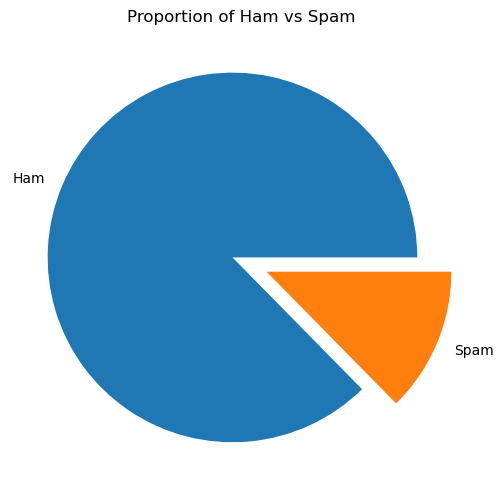

In [10]:
# Count the number of ham and spam messages
label_counts = df['Class'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    label_counts, 
    labels=['Ham', 'Spam'],  
    explode=(0.05, 0.15),  
    )
plt.title('Proportion of Ham vs Spam')  
plt.show()


In [11]:
# Feature engineering: Adding a Word Count feature
# Calculate the number of words in each SMS message
df['Word_Count'] = df['Text'].apply(lambda x: len(str(x).split()))

# Feature engineering: Adding a Character Count feature
# Calculate the number of characters in each SMS message
df['Char_Count'] = df['Text'].apply(lambda x: len(str(x)))

# Feature engineering: Adding Average Word Length feature
# Calculate the average word length in each message (handling division by zero for empty messages)
df['Avg_Word_Length'] = df.apply(
    lambda row: row['Char_Count'] / row['Word_Count'] if row['Word_Count'] > 0 else 0, axis=1
)

# Display the first few rows to check the new features
df.head()

,Class,Text,Word_Count,Char_Count,Avg_Word_Length
0,ham,"Go until jurong point, crazy.. Available only ...",20,111,5.550000
1,ham,Ok lar... Joking wif u oni...,6,29,4.833333
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,155,5.535714
3,ham,U dun say so early hor... U c already then say...,11,49,4.454545
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,61,4.692308


In [12]:
# Show a summary of the descriptive statistics, including the new features
df.describe()

,Word_Count,Char_Count,Avg_Word_Length
count,5169.000000,5169.000000,5169.000000
mean,15.340685,78.923776,5.165399
std,11.068488,58.174846,1.128830
min,1.000000,2.000000,2.000000
25%,7.000000,36.000000,4.571429
50%,12.000000,60.000000,5.000000
75%,22.000000,117.000000,5.571429
max,171.000000,910.000000,49.000000


In [13]:
from sklearn.preprocessing import MinMaxScaler
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from collections import Counter

# Step 1: Normalize numerical features using MinMaxScaler
scaler = MinMaxScaler()
df[['Word_Count', 'Char_Count', 'Avg_Word_Length']] = scaler.fit_transform(df[['Word_Count', 'Char_Count', 'Avg_Word_Length']])

# Step 2: Define a function to normalize text
def normalize_text(text):
    """
    Perform text normalization to preprocess messages for analysis.
    Steps:
    - Lowercase conversion
    - Abbreviation handling
    - Stopword removal
    - Punctuation and non-alphabetic character removal
    - Rare word removal based on frequency
    """
    # Initialize the stopwords set
    stop_words = set(stopwords.words('english'))
    
    # Define a dictionary for custom abbreviation expansion
    abbreviations = {
        "la": "",        # Example: Remove meaningless filler
        "wat": "what",   # Example: Correct informal spelling
        "n": "and",      # Example: Expand abbreviation
        "ur": "your",    # Example: Shortened word for "your"
        "u": "you"       # Example: Replace shorthand with the full word
    }
    
    # Convert the input text to lowercase to ensure uniformity
    text = text.lower()
    
    # Expand abbreviations by replacing them with full forms
    words = text.split()  # Split the text into individual words
    words = [abbreviations.get(word, word) for word in words]  # Replace abbreviations
    text = " ".join(words)  # Join the processed words back into a string
    
    # Tokenize the text into individual words for further processing
    words = word_tokenize(text)
    
    # Remove punctuation, non-alphabetic characters, and stopwords
    words = [re.sub(r"[^\w\s]", "", word) for word in words if word.isalpha() and word not in stop_words]
    
    # Rare words removal: Identify and remove words that appear less than twice in the dataset
    word_counts = Counter(" ".join(df['Message']).split())  # Count word frequencies in the entire dataset
    rare_words = {word for word, count in word_counts.items() if count < 2}  # Identify rare words
    words = [word for word in words if word not in rare_words]  # Exclude rare words from the tokenized text
    
    # Join the processed words back into a single normalized string
    normalized_text = " ".join(words)
    
    return normalized_text

In [14]:
# Download essential NLTK packages for text processing
import nltk
nltk.download('wordnet')  # Download WordNet for lemmatization support
nltk.download('omw-1.4')  # Ensure full lemmatization support for additional languages

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aafaq\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aafaq\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [15]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk
import re

# Ensure NLTK uses the correct path for its data
nltk.data.path.append("C:\\Users\\aafaq\\AppData\\Roaming\\nltk_data")  # Adjust the path if needed

# Initialize Porter Stemmer and set of stopwords
stemmer = PorterStemmer()  # For stemming words to their root forms
stop_words = set(stopwords.words('english'))  # Common stopwords to be removed from the text

# Custom abbreviation mapping for commonly used SMS slang and shorthand
abbreviations = {
    "u": "you",     # Replace "u" with "you"
    "ur": "your",   # Replace "ur" with "your"
    "la": "the",    # Replace "la" with "the"
    "wat": "what",  # Replace "wat" with "what"
    "n": "and",     # Replace "n" with "and"
    "e": "the"      # Replace "e" with "the"
}

def normalize_text(text):
    """
    Perform text normalization on an input string.
    The steps include:
    - Convert text to lowercase
    - Expand SMS abbreviations
    - Remove punctuation, stopwords, and non-alphabetic tokens
    - Apply stemming to reduce words to their root forms

    Args:
    text (str): Input text to normalize

    Returns:
    str: Normalized and cleaned text
    """
    # Convert the input text to lowercase for uniformity
    text = text.lower()

    # Tokenize the text into individual words
    try:
        words = word_tokenize(text)  # Tokenize using nltk
    except LookupError as e:
        print(f"Tokenizer not found. Ensure punkt is downloaded. Error: {e}")
        return None

    # Expand abbreviations using the predefined dictionary
    words = [abbreviations.get(word, word) for word in words]

    # Remove punctuation, stopwords, and non-alphabetic words
    words = [re.sub(r"[^\w\s]", "", word) for word in words if word.isalpha() and word not in stop_words]

    # Apply stemming to reduce words to their root forms
    words = [stemmer.stem(word) for word in words]

    # Join the cleaned and processed words back into a single string
    normalized_text = " ".join(words)
    return normalized_text

In [16]:
# Apply the text normalization function to the 'Message' column in the DataFrame
df['Normalized_Text'] = df['Text'].apply(normalize_text)

# Display the first few rows of the updated DataFrame for verification
df[['Text', 'Normalized_Text']].head()

,Text,Normalized_Text
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi great world b...
1,Ok lar... Joking wif u oni...,ok lar joke wif oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt may ...
3,U dun say so early hor... U c already then say...,dun say earli hor c alreadi say
4,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though


In [17]:
df.head()

,Class,Text,Word_Count,Char_Count,Avg_Word_Length,Normalized_Text
0,ham,"Go until jurong point, crazy.. Available only ...",0.111765,0.120044,0.075532,go jurong point crazi avail bugi great world b...
1,ham,Ok lar... Joking wif u oni...,0.029412,0.029736,0.060284,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,0.158824,0.168502,0.075228,free entri wkli comp win fa cup final tkt may ...
3,ham,U dun say so early hor... U c already then say...,0.058824,0.051762,0.052224,dun say earli hor c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0.070588,0.064978,0.057283,nah think goe usf live around though


In [18]:
# Import required libraries
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack

# Configure Pandas to display complete content of text columns without truncation
pd.set_option('display.max_colwidth', None)

# Display the original and normalized messages from the first row of the DataFrame
first_row = df.iloc[0]
print(f"Original Text: {first_row['Text']}")
print(f"Normalized Text: {first_row['Normalized_Text']}")

Original Text: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Normalized Text: go jurong point crazi avail bugi great world buffet cine got amor


In [19]:
# Count the frequency of words in spam and ham messages using the 'Counter' class
spam_word_counts = Counter(" ".join(df[df['Class'] == 'spam']['Normalized_Text']).split())
ham_word_counts = Counter(" ".join(df[df['Class'] == 'ham']['Normalized_Text']).split())

# Display the most frequently occurring words in spam messages
print("Top 10 Words in Spam Messages:")
print("." * 40)
print(f"{'Word':<15} | {'Frequency':<10}")
print("." * 40)
for word, frequency in spam_word_counts.most_common(10):
    print(f"{word:<15} | {frequency:<10}")
print("\n")

# Display the most frequently occurring words in ham messages
print("Top 10 Words in Ham Messages:")
print("." * 40)
print(f"{'Word':<15} | {'Frequency':<10}")
print("." * 40)
for word, frequency in ham_word_counts.most_common(10):
    print(f"{word:<15} | {frequency:<10}")
print("\n")

Top 10 Words in Spam Messages:
........................................
Word            | Frequency 
........................................
call            | 320       
free            | 191       
txt             | 141       
text            | 122       
mobil           | 114       
stop            | 104       
repli           | 103       
claim           | 98        
prize           | 82        
get             | 74        


Top 10 Words in Ham Messages:
........................................
Word            | Frequency 
........................................
go              | 404       
get             | 349       
gt              | 288       
lt              | 287       
come            | 275       
got             | 236       
know            | 236       
like            | 234       
call            | 233       
time            | 219       




In [20]:
# Map spam and ham classes to numerical values for model compatibility
# 'ham' is represented as 0, while 'spam' is represented as 1
df['Class'] = df['Class'].map({'ham': 0, 'spam': 1})

# Split data into features (X) and target labels (y)
X = df['Text']
y = df['Class']

# Convert text messages into numerical vectors using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_transformed = tfidf_vectorizer.fit_transform(X)

# Apply Synthetic Minority Oversampling Technique (SMOTE) to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_transformed, y)

# Print the class distribution before and after applying SMOTE
print("Class Distribution Before SMOTE:")
print(y.value_counts())
print("\nClass Distribution After SMOTE:")
print(pd.Series(y_resampled).value_counts())

Class Distribution Before SMOTE:
Class
0    4516
1     653
Name: count, dtype: int64

Class Distribution After SMOTE:
Class
0    4516
1    4516
Name: count, dtype: int64


In [21]:
# Import required libraries for model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import joblib
import pandas as pd

# Split the dataset into training and testing sets
# 80% of the data is used for training, and 20% is used for testing
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# Display the distribution of classes in the training set
print("Training Set Class Distribution:")
print(pd.Series(y_train).value_counts())

Training Set Class Distribution:
Class
0    3632
1    3593
Name: count, dtype: int64


In [22]:
# Initialize the Naive Bayes model
naive_bayes_model = MultinomialNB()

# Train the model using the training data
naive_bayes_model.fit(X_train, y_train)

MultinomialNB()

In [23]:
# Use the trained model to predict labels for the test set
y_pred = naive_bayes_model.predict(X_test)

# Evaluate the model's performance
print("Model Evaluation Metrics:")

# Display accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Evaluation Metrics:
Accuracy: 0.99

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       884
           1       0.99      0.99      0.99       923

    accuracy                           0.99      1807
   macro avg       0.99      0.99      0.99      1807
weighted avg       0.99      0.99      0.99      1807



In [24]:
# Save the trained model to a file using Joblib
model_file = "naive_bayes_model.pkl"
joblib.dump(naive_bayes_model, model_file)
print(f"Model saved as {model_file}.")

Model saved as naive_bayes_model.pkl.


In [25]:
# Save the TF-IDF vectorizer to a file for use during inference
vectorizer_file = "tfidf_vectorizer.pkl"
joblib.dump(tfidf_vectorizer, vectorizer_file)
print(f"TF-IDF vectorizer saved as {vectorizer_file}.")

TF-IDF vectorizer saved as tfidf_vectorizer.pkl.


In [26]:
def predict_message(message, model, vectorizer):
    """
    Predicts whether a given message is spam or not.

    Args:
        message (str): The message to classify.
        model: The trained classification model (e.g., Naive Bayes).
        vectorizer: The trained TF-IDF vectorizer used to preprocess text.

    Returns:
        tuple: A label ("Spam" or "Not Spam") and the probabilities for each class.
    """
    # Define the mapping of numeric labels to human-readable labels
    label_mapping = {
        0: "Not Spam",  # Class 0 corresponds to "Not Spam"
        1: "Spam"       # Class 1 corresponds to "Spam"
    }
    
    # Transform the input message using the TF-IDF vectorizer
    message_transformed = vectorizer.transform([message])
    
    # Predict the class (0 or 1) for the message
    predicted_class = model.predict(message_transformed)[0]
    
    # Predict probabilities for both classes (0 and 1)
    predicted_probabilities = model.predict_proba(message_transformed)[0]
    
    # Map the numeric predicted class to its corresponding label
    predicted_label = label_mapping[predicted_class]
    
    return predicted_label, predicted_probabilities

In [28]:
def main():
    # Ask the user how many messages they want to classify
    num_messages = int(input("How many messages would you like to classify? "))
    
    # Loop through and accept each message from the user
    for i in range(num_messages):
        print(f"\nMessage {i + 1}:")
        message = input("Enter the message: ")
        
        # Predict the message class
        predicted_label, predicted_probabilities = predict_message(message, naive_bayes_model, tfidf_vectorizer)
        
        # Display the results
        print(f"\nPrediction for Message {i + 1}:")
        print(f"Predicted Label: {predicted_label}")
        print(f"Prediction Probabilities: {predicted_probabilities}")
        print("-" * 50)


# Execute the main function
if __name__ == "__main__":
    main()

How many messages would you like to classify?  2



Message 1:


Enter the message:  Congratulations! You've won a free iPhone! Claim your prize now by clicking the link below. Limited time offer!



Prediction for Message 1:
Predicted Label: Spam
Prediction Probabilities: [0.01457328 0.98542672]
--------------------------------------------------

Message 2:


Enter the message:  Hi Siri, can we reschedule our meeting for next Monday? Let me know what time works best for you. Thanks!



Prediction for Message 2:
Predicted Label: Not Spam
Prediction Probabilities: [0.95999142 0.04000858]
--------------------------------------------------
